# Scenario modelling

In [1]:
scn = "SCN_BASE"
BASELINE = "BASELINE"
SCN_BASE = "SCN_BASE"
SCN_MIN_LEY = "SCN_MIN_LEY"
SCN_REDUCED_MILK = "SCN_REDUCED_MILK"
SCN_SNG = "SCN_SNG"

## Set up environment

In [2]:
CM_BASEPATH = '../cibusmod'

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), CM_BASEPATH))

In [3]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import time
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [4]:
from CIBUSmod.utils.misc import inv_dict, aggregate_data_coords_pair
from CIBUSmod.optimisation.indexed_matrix import IndexedMatrix
from CIBUSmod.optimisation.utils import make_cvxpy_constraint
from itertools import product

In [5]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import PercentFormatter

In [6]:
def block_print(msg: str, N=80):
    print("=" * N)
    print("=" * N)
    if len(msg) >= N-2:
        print(msg)
    else:
        _n = int((N - len(msg)) / 2) - 1
        _n2 = _n + len(msg) % 2
        print(_n * "-" + f" {msg} " + "-" * _n2)
    print("=" * N)
    print("=" * N)

In [7]:
# Create session
session = cm.Session(
    name = 'main',
    data_path = "data",
    data_path_default = CM_BASEPATH + "/data/default",
)

## Share of land use per region

In [8]:
x0_lu_per_region = session.get_attr("r", "x0_crops", "region")
x_lu_per_region = session.get_attr("f", "x_crops", "region")
delta_lu_per_region = (x0_lu_per_region - x0_lu_per_region)

In [9]:
for _scn, year in delta_lu_per_region.index:
    if all(delta_lu_per_region == 0):
        block_print(f"{_scn}: All land used")
        print("")
    else:
        print(_scn)
        cm.plot.map_from_series(delta_lu_per_region[(_scn, year)])

--------------------------- BASELINE: All land used ----------------------------

--------------------------- SCN_BASE: All land used ----------------------------

-------------------------- SCN_MIN_LEY: All land used --------------------------

----------------------- SCN_REDUCED_MILK: All land used ------------------------

---------------------------- SCN_SNG: All land used ----------------------------



## Change in crops

Plots if crops increased or decarsed in amounts in each region.

### Change in total crops per region, compared to x0

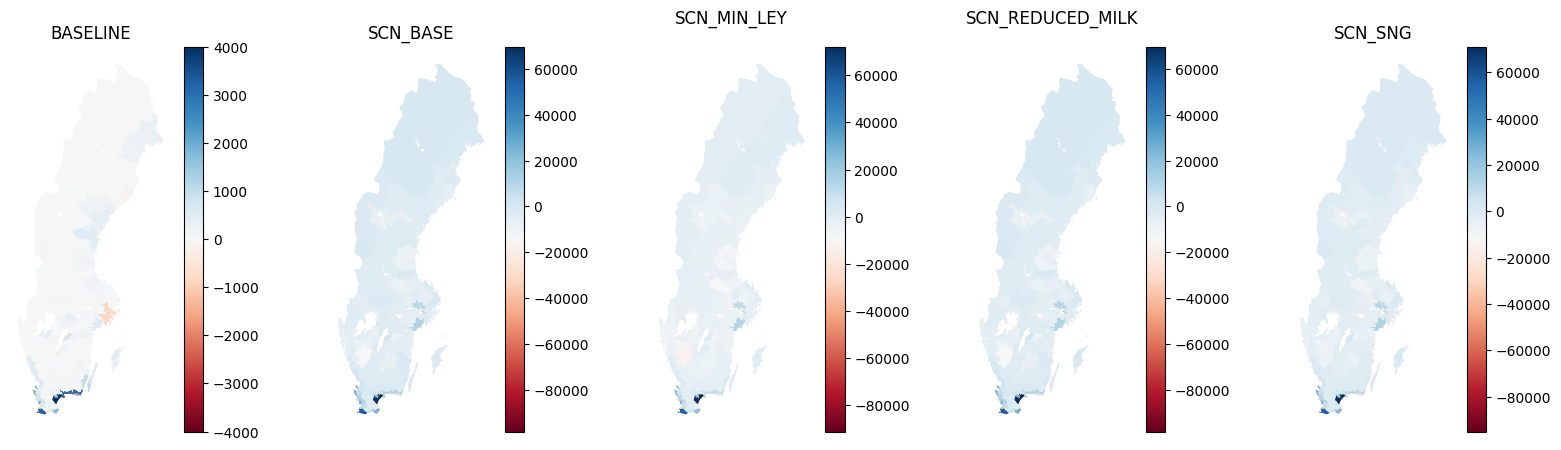

In [10]:
x0_crops_per_region = session.get_attr("r", "x0_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
x_crops_per_region = session.get_attr("f", "x_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
delta = x_crops_per_region - x0_crops_per_region

fig, axs = plt.subplots(1, len(session.scenarios()), figsize=(20, 5))
for scn, ax in zip(list(session.scenarios().keys()), axs):
    try:
        data = delta.loc[(scn, "2020"),:]
    except Exception:
        continue
    
    ax.set_axis_off()
    ax.set_title(scn)
    plot.map_from_series(delta.loc[(scn, "2020"),:], cmap="RdBu", ax=ax)

### Change in total crops per region, compared to the baseline

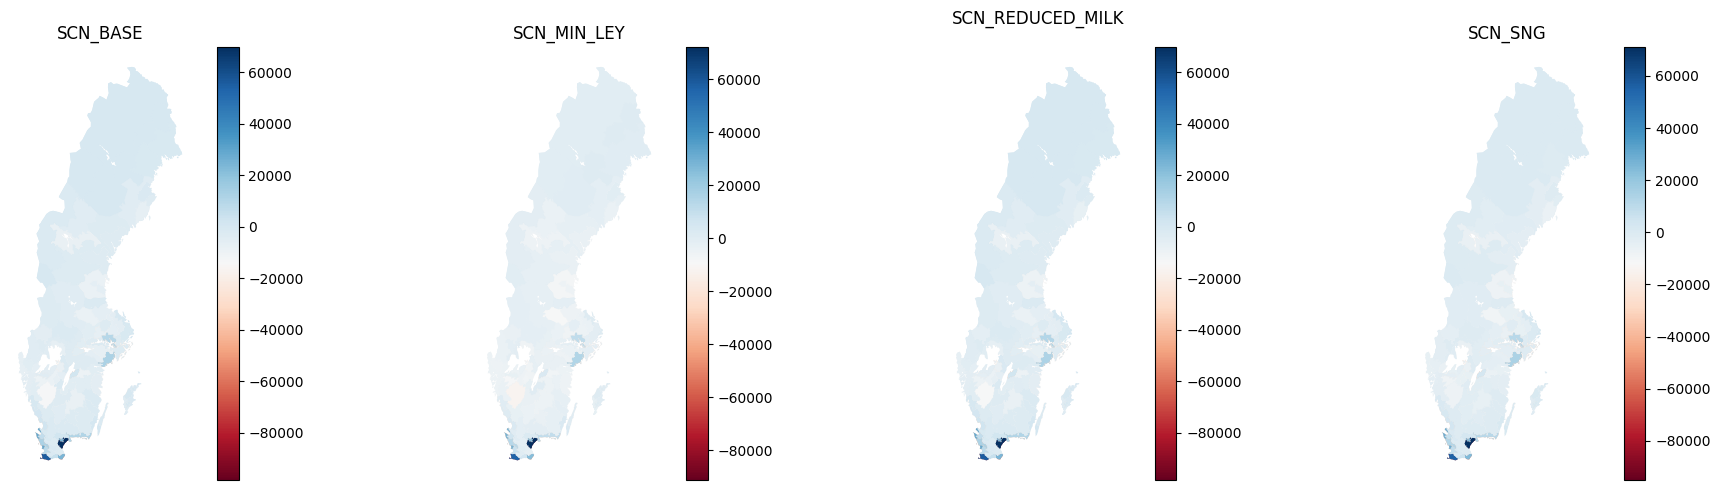

In [34]:
BL_crops_per_region = session.get_attr("r", "x0_crops", ["prod_system", "region"], scn="BASELINE").loc[("BASELINE","2020")]
SCNS_crops_per_region = session.get_attr("f", "x_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
SCNS_crops_per_region = SCNS_crops_per_region.drop([("BASELINE", "2020")])
delta = SCNS_crops_per_region - BL_crops_per_region

scenarios = [s for s in session.scenarios().keys() if s != "BASELINE"]
fig, axs = plt.subplots(1, len(scenarios), figsize=(20, 5))
for scn, ax in zip(scenarios, axs):
    ax.set_axis_off()
    ax.set_title(scn)
    
    try:
        data = delta.loc[(scn, "2020"),:]
    except Exception:
        continue
    
    plot.map_from_series(data, cmap="RdBu", ax=ax)
fig.tight_layout()

## Share of byproducts used

In [12]:
D_byprod = session.get_attr("d", "by_products")
# Subtract food uses of by-products
used_byprod = session.get_attr("d", "by_prod_demand").xs("food", level="demand", axis=1)
D_byprod = D_byprod - used_byprod.reindex(D_byprod.columns, axis=1).fillna(0)
D_byprod

prod_system            conventional                                     \
by_prod                  apple pulp barley brewers grain   butcher fat   
origin                     domestic             domestic      domestic   
scn              year                                                    
BASELINE         2020  5.084329e+06         9.312015e+07  5.577411e+07   
SCN_BASE         2020  5.084329e+06         9.312015e+07  4.244275e+07   
SCN_MIN_LEY      2020  5.084329e+06         9.312015e+07  4.244275e+07   
SCN_REDUCED_MILK 2020  5.084329e+06         9.312015e+07  4.244275e+07   
SCN_SNG          2020  5.084329e+06         9.312015e+07  4.244275e+07   

prod_system                                                                    \
by_prod                  buttermilk  edible blood edible offals      feathers   
origin                     domestic      domestic      domestic      domestic   
scn              year                                                           
BASELINE         2020  3.706088e+07  1.993502e+07  2.126410e+07  4.384669e+07   
SCN_BASE         2020  0.000000e+00  1.032106e+07  6.309053e+06  4.384669e+07   
SCN_MIN_LEY      2020  0.000000e+00  1.032106e+07  6.309053e+06  4.384669e+07   
SCN_REDUCED_MILK 2020  0.000000e+00  1.032106e+07  6.309053e+06  4.384669e+07   
SCN_SNG          2020  0.000000e+00  1.032106e+07  6.309053e+06  4.384669e+07   

prod_system                                                         ...  \
by_prod                   fish meal inedible blood inedible offals  ...   
origin                     imported       domestic        domestic  ...   
scn              year                                               ...   
BASELINE         2020  3.338158e+06   6.766314e+06    5.011931e+07  ...   
SCN_BASE         2020  3.338158e+06   6.766314e+06    5.011931e+07  ...   
SCN_MIN_LEY      2020  3.338158e+06   6.766314e+06    5.011931e+07  ...   
SCN_REDUCED_MILK 2020  3.338158e+06   6.766314e+06    5.011931e+07  ...   
SCN_SNG          2020  3.338158e+06   6.766314e+06    5.011931e+07  ...   

prod_system                      organic                \
by_prod               slaughterhouse fat  soybean meal   
origin                          domestic      imported   
scn              year                                    
BASELINE         2020       1.916671e+06  3.794208e+06   
SCN_BASE         2020       5.002065e+05  3.764469e+06   
SCN_MIN_LEY      2020       5.002065e+05  3.764469e+06   
SCN_REDUCED_MILK 2020       5.002065e+05  3.764469e+06   
SCN_SNG          2020       5.002065e+05  3.764469e+06   

prod_system                                                            \
by_prod               soybean protein concentrate sugar beet molasses   
origin                                   imported            imported   
scn              year                                                   
BASELINE         2020                53026.107968        6.329535e+07   
SCN_BASE         2020                53024.933125        5.607111e+04   
SCN_MIN_LEY      2020                53024.933125        5.607111e+04   
SCN_REDUCED_MILK 2020                53024.933125        5.607111e+04   
SCN_SNG          2020                53024.933125        5.607111e+04   

prod_system                                                \
by_prod               sugar beet pulp sunflower seed meal   
origin                       imported            imported   
scn              year                                       
BASELINE         2020    4.256176e+07        76669.915795   
SCN_BASE         2020    7.595611e+04        76597.969772   
SCN_MIN_LEY      2020    7.595611e+04        76597.969772   
SCN_REDUCED_MILK 2020    7.595611e+04        76597.969772   
SCN_SNG          2020    7.595611e+04        76597.969771   

prod_system                                                               \
by_prod               wheat distillers grain                        whey   
origin                              domestic

(<Axes: >, [<Axes: label='inset_axes'>])

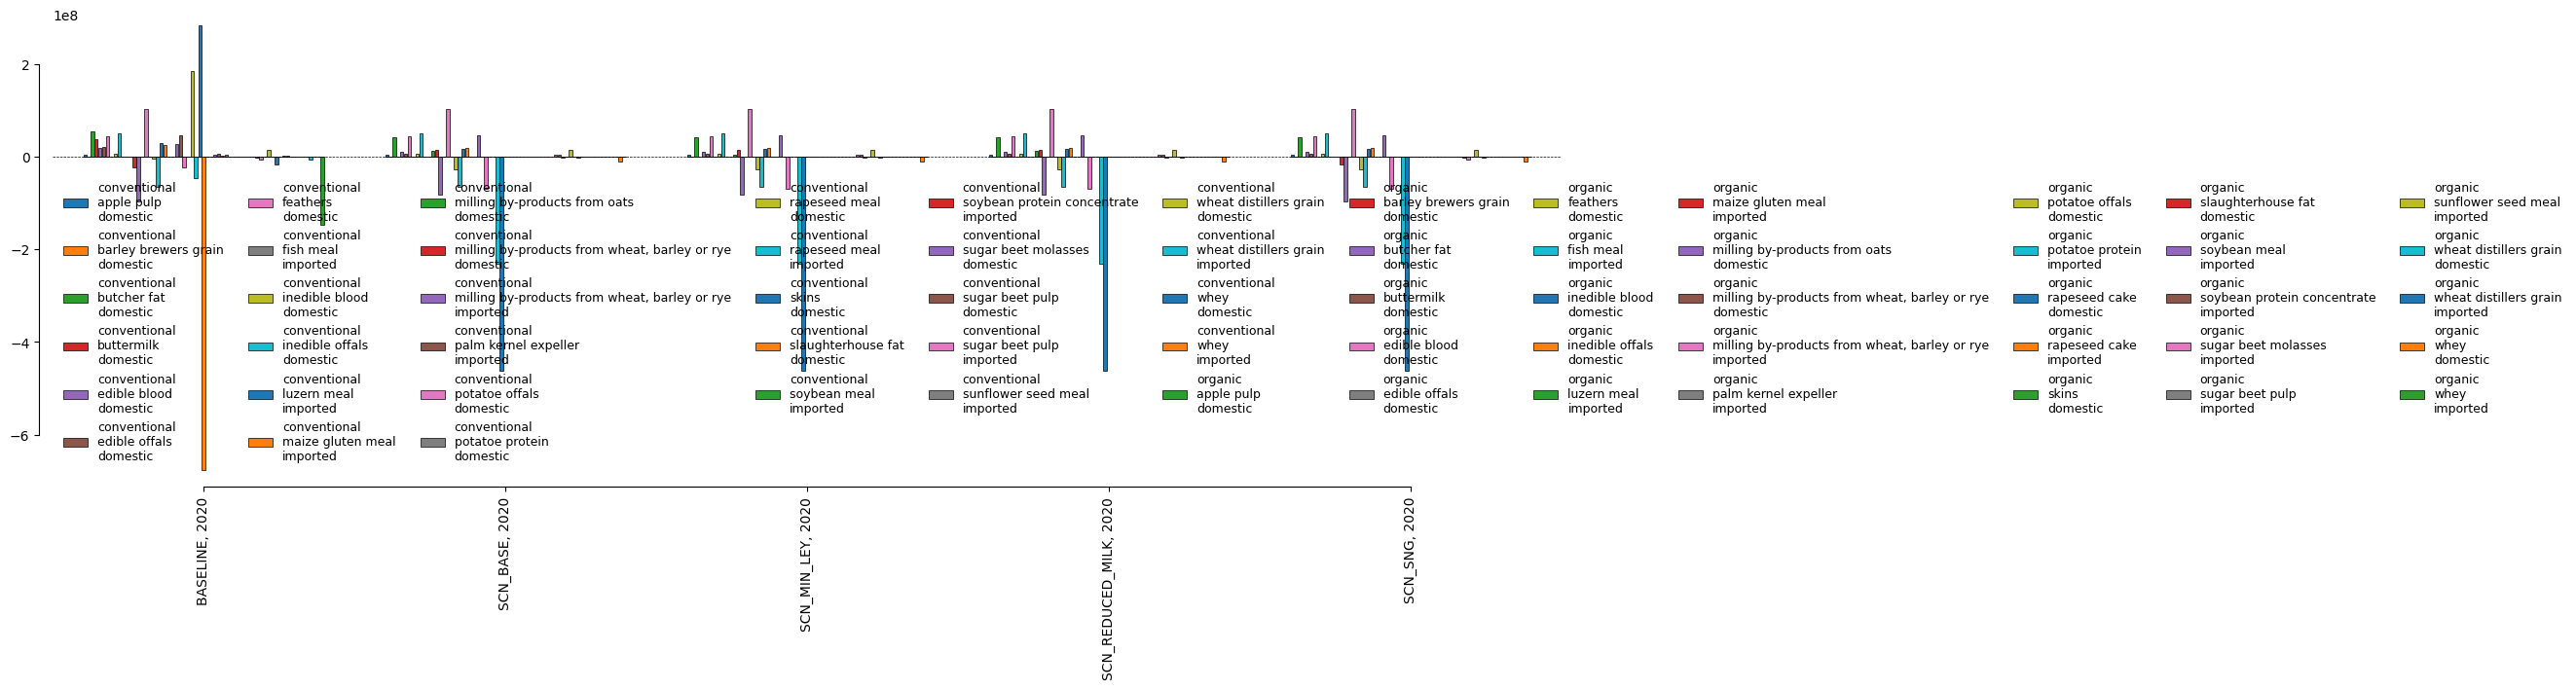

In [14]:
F_byprod = session.get_attr("ani", "feed.by_product_demand", ["prod_system", "by_prod"])
F_byprod = F_byprod.reindex(D_byprod.columns, axis=1).fillna(0)
net_byprod = D_byprod - F_byprod

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
plot.bar(
    net_byprod,
    stacked=False,
    ax=ax
)

,animal_prod,milk,meat
scn,year,,
BASELINE,2020,2.817160e+09,5.438627e+08
SCN_BASE,2020,1.819319e+09,4.554598e+08
SCN_MIN_LEY,2020,1.912753e+09,5.468176e+08
SCN_REDUCED_MILK,2020,1.579779e+09,4.597820e+08
SCN_SNG,2020,1.819319e+09,4.856705e+08


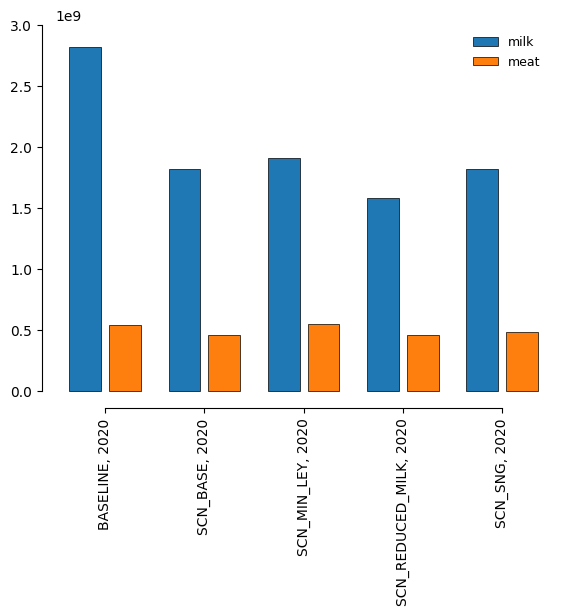

In [15]:
meatmilk_prod = session.get_attr('a', 'production', "animal_prod")[["milk", "meat"]]
plot.bar(meatmilk_prod, stacked=False)
meatmilk_prod

,crop,Wheat (add),Peas (add)
scn,year,,
SCN_BASE,2020,5.459926e+09,1.155990e+09
SCN_MIN_LEY,2020,3.053073e+09,1.151523e+09
SCN_REDUCED_MILK,2020,5.497368e+09,1.156028e+09
SCN_SNG,2020,4.678899e+09,1.151612e+09


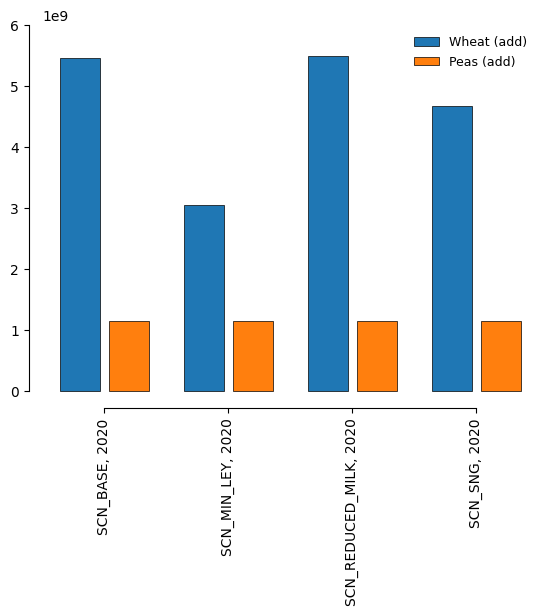

In [16]:
crop_prod = session.get_attr("c", "harvest", "crop")[["Wheat (add)", "Peas (add)"]]
crop_prod = crop_prod.drop(("BASELINE", "2020"))
plot.bar(crop_prod, stacked=False)
crop_prod

## Chloropleth maps over added crops/meat

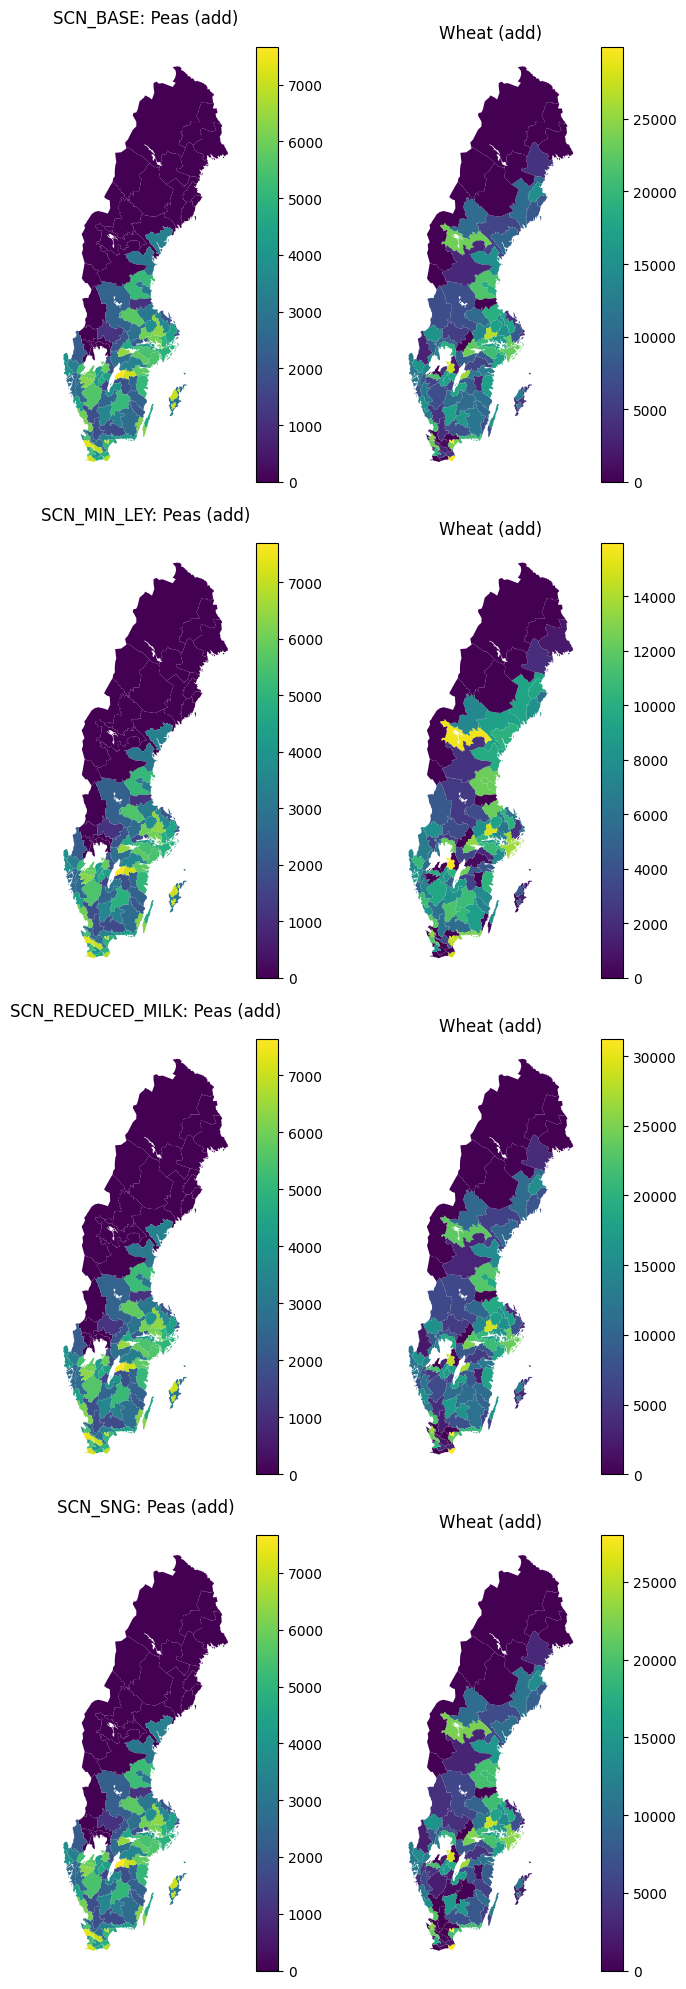

In [17]:
def plot_crop_x0_x_chloropleths(): 
    def get_x(crp: str):
        return session.get_attr("f", "x_crops").xs(crp, level="crop", drop_level=False, axis=1)
    
    crops = pd.concat([get_x("Peas (add)"), get_x("Wheat (add)")], axis=1)
    cps = crops.columns.unique("crop")
    crops = crops.drop(("BASELINE", "2020"))

    ncols = len(cps)
    nrows = crops.shape[0]
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*5))

    if nrows == 1:
        axs = [axs]

    for scn_i, (scn, _year) in enumerate(crops.index):
        for crp_i, crp in enumerate(cps):
            data=crops.loc[(scn, _year),(crp, "conventional",)]
            ax=axs[scn_i][crp_i]
            ax.set_axis_off()
            title = crp
            if crp_i == 0:
                title = f"{scn}: {title}"
            ax.set_title(title)
                
            cm.plot.map_from_series(data, ax=ax)
    fig.tight_layout()

plot_crop_x0_x_chloropleths()

----------------------------------- SCN_BASE -----------------------------------


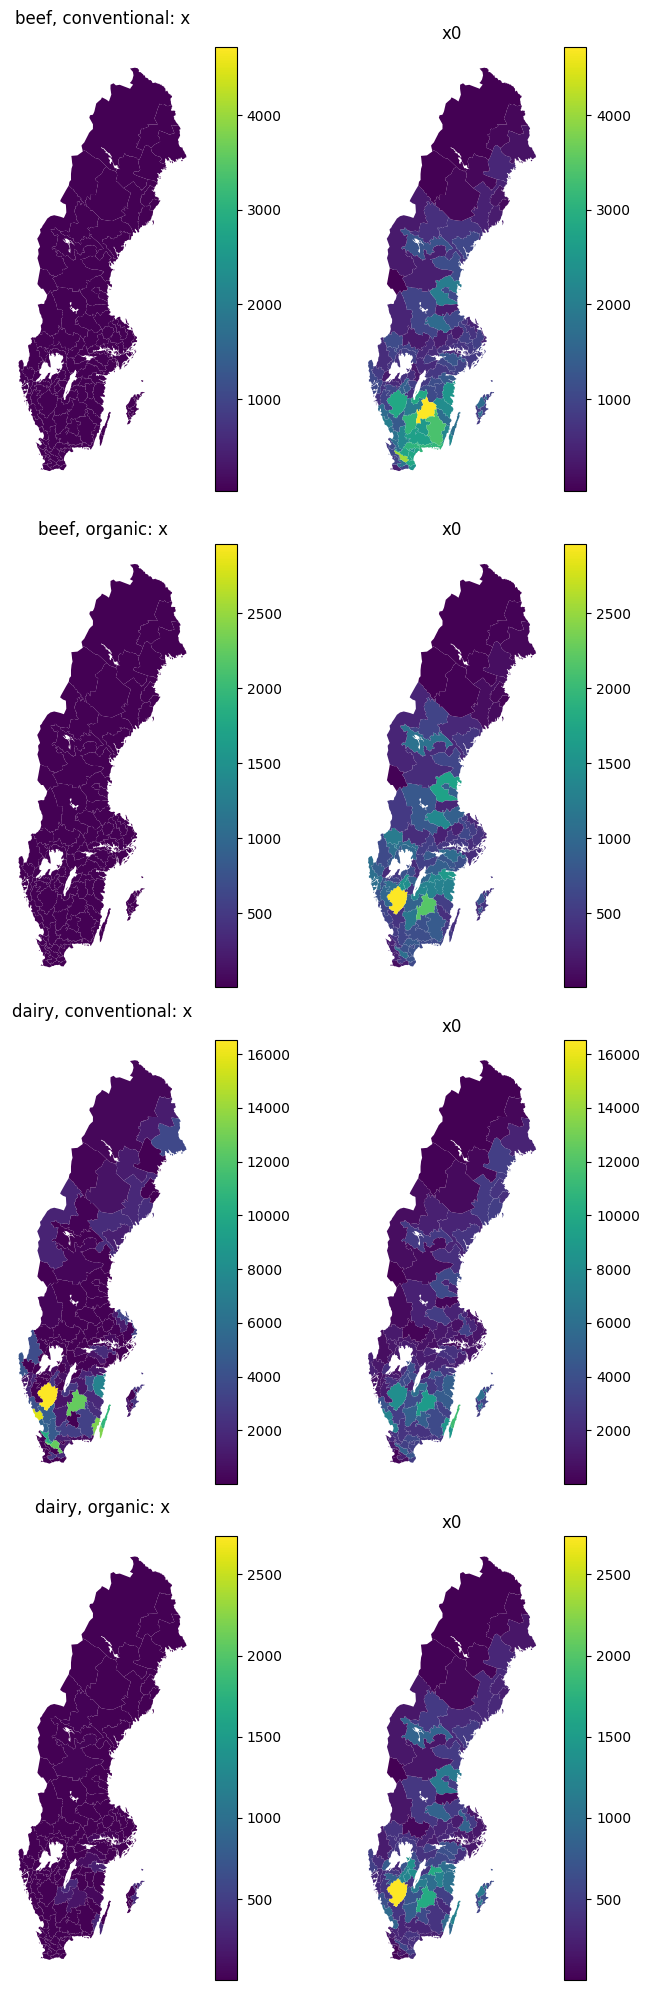

--------------------------------- SCN_MIN_LEY ----------------------------------


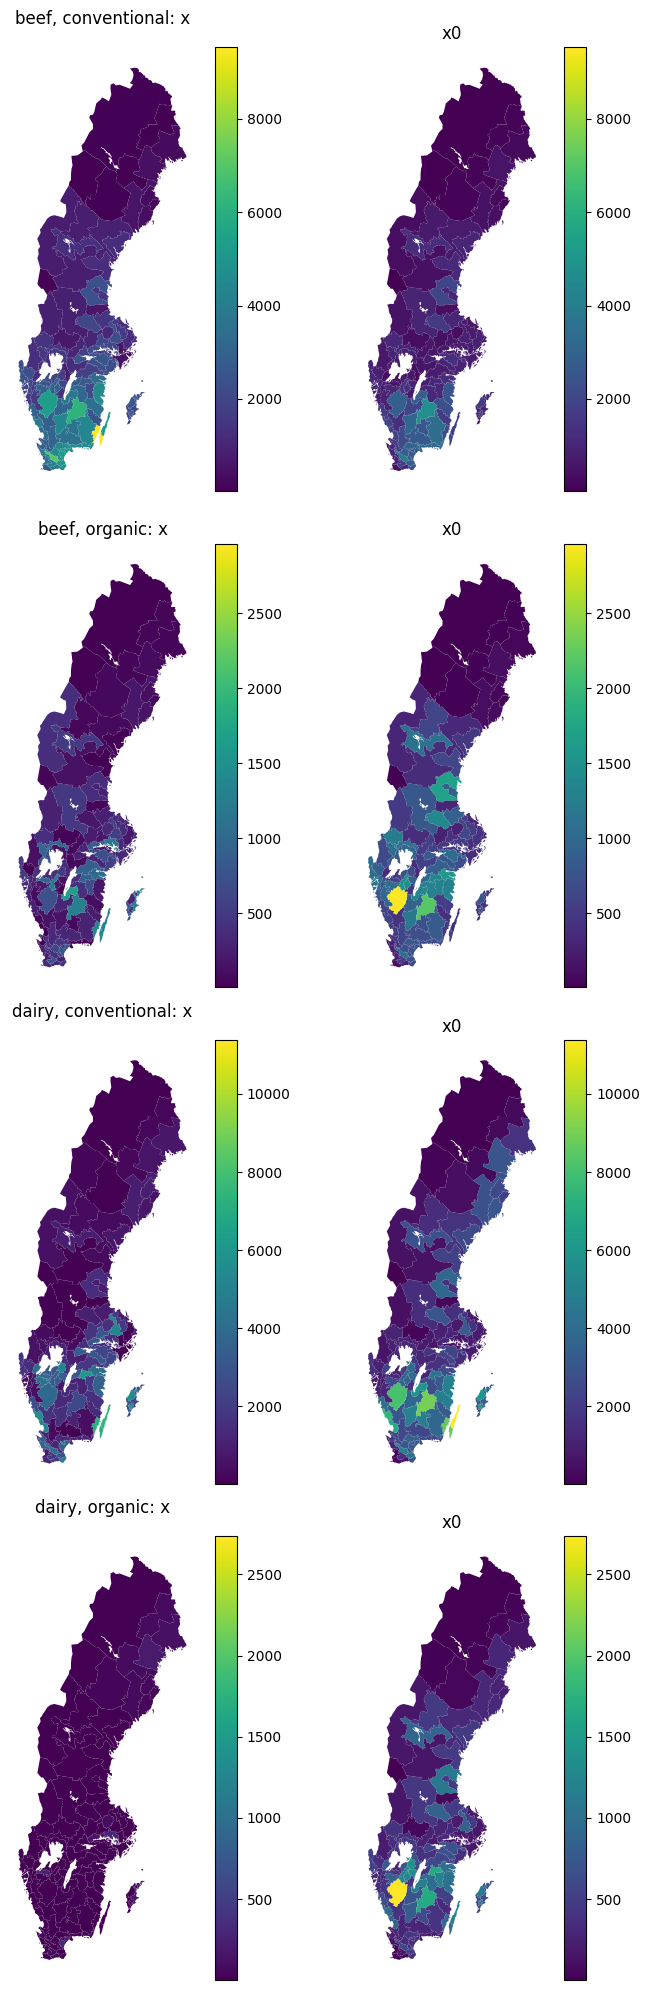

------------------------------- SCN_REDUCED_MILK -------------------------------


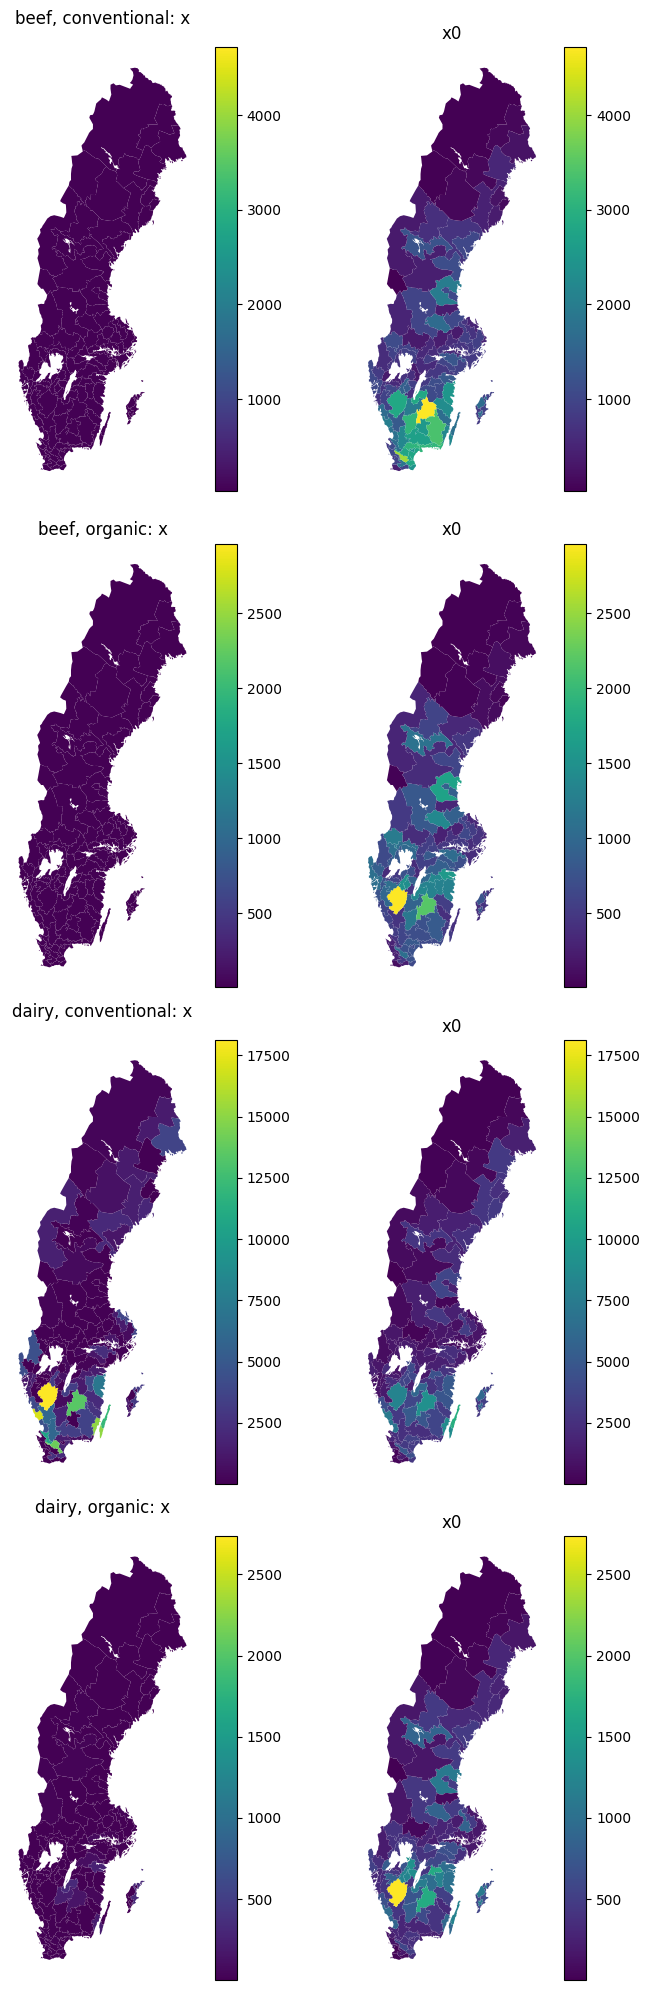

----------------------------------- SCN_SNG ------------------------------------


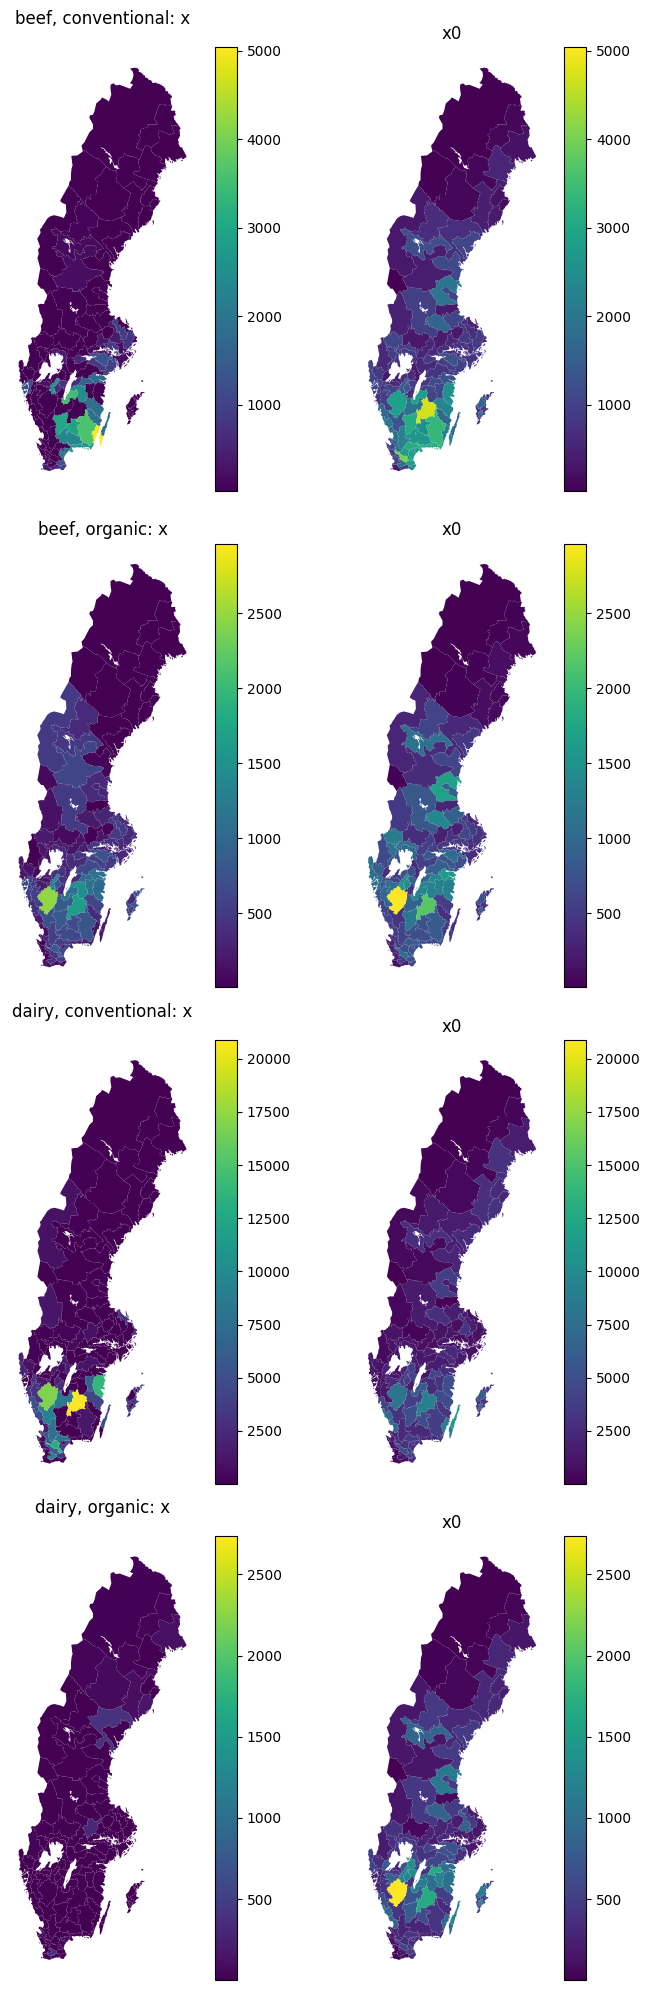

In [18]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import PercentFormatter

def plot_cattle_x0_x_chloropleths():
    all_x0_cattle = session.get_attr("r", "x0_animals").xs("cattle", level="species", axis=1)
    all_x_cattle = session.get_attr("f", "x_animals", ["species", "breed", "prod_system", "region"]).xs("cattle", level="species", axis=1)

    for scn in all_x_cattle.index.get_level_values("scn"):
        if scn == "BASELINE": 
            continue
        block_print(scn)
        x0_cattle = all_x0_cattle.loc[(scn, "2020")].unstack("region")
        x_cattle = all_x_cattle.loc[(scn, "2020")].unstack("region")
        
        assert (x0_cattle.index == x_cattle.index).all(), "Expected index of x0 and x to match"
        
        N = len(x0_cattle.index.values)
        fig, axes = plt.subplots(N, 2, figsize=(8, N * 5))
        
        for pos, axs in zip(x0_cattle.index, axes):
            (ax_x, ax_x0) = axs
            
            x = x_cattle.loc[pos,:]
            x0 = x0_cattle.loc[pos,:]
            
        
            # Absolute values: x and x0
            # -------------------------
            ax_x.set_axis_off()
            ax_x0.set_axis_off()
            x_vmax = max(x.max(), x0.max())
            x_vmin = max(x.min(), x0.min())
            ax_x.set_title(f"{pos[0]}, {pos[1]}: x")
            ax_x0.set_title("x0")
            cm.plot.map_from_series(x, ax=ax_x, vmin=x_vmin, vmax=x_vmax)
            cm.plot.map_from_series(x0, ax=ax_x0, vmin=x_vmin, vmax=x_vmax)
        
        fig.tight_layout()
        plt.show()

plot_cattle_x0_x_chloropleths()

In [19]:
session.get_attr("f", "x_crops").xs("Peas (add)", level="crop", axis=1)

prod_system           conventional                                         \
region                        1011          111         1111         1112   
scn              year                                                       
BASELINE         2020     0.000000     0.000000     0.000000     0.000000   
SCN_BASE         2020  4299.123078  4930.631218  5032.552697  3393.165766   
SCN_MIN_LEY      2020  4299.123078  4843.877320  4925.330953  3455.451581   
SCN_REDUCED_MILK 2020  4299.123078  4989.386608  5032.552697  3360.126267   
SCN_SNG          2020  4291.918339  4909.267435  5032.552697  3428.485730   

prod_system                                                                \
region                         112         1121         1122         1123   
scn              year                                                       
BASELINE         2020     0.000000     0.000000     0.000000     0.000000   
SCN_BASE         2020  4407.627410  6804.505431  4909.707611  5410.217948   
SCN_MIN_LEY      2020  4485.106714  6804.068096  4909.707611  5405.599963   
SCN_REDUCED_MILK 2020  4361.466875  6804.954760  4909.707611  5410.217948   
SCN_SNG          2020  4410.483139  6804.863059  4886.475713  5407.685204   

prod_system                                      ...               \
region                        1124         1131  ...          731   
scn              year                            ...                
BASELINE         2020     0.000000     0.000000  ...     0.000000   
SCN_BASE         2020  2515.957952  1847.470559  ...  1726.912904   
SCN_MIN_LEY      2020  2489.911243  1847.470559  ...  1726.912904   
SCN_REDUCED_MILK 2020  2516.557533  1847.470559  ...  1726.912904   
SCN_SNG          2020  2481.603900  1838.471464  ...  1707.395836   

prod_system                                                                \
region                         811          812          813          814   
scn              year                                                       
BASELINE         2020     0.000000     0.000000     0.000000     0.000000   
SCN_BASE         2020  6255.811890  4601.000569  2125.961109  2379.029252   
SCN_MIN_LEY      2020  6286.462472  4595.489159  2125.961109  2379.029252   
SCN_REDUCED_MILK 2020  6252.371263  4606.512337  2125.961109  2379.029252   
SCN_SNG          2020  6305.365444  4607.734414  2121.909562  2354.557883   

prod_system                                                                \
region                         821          831          911          912   
scn              year                                                       
BASELINE         2020     0.000000     0.000000     0.000000     0.000000   
SCN_BASE         2020  5099.181705  2724.763502  3216.969061  7072.623252   
SCN_MIN_LEY      2020  5068.596495  2724.763502  3227.224063  7137.829061   
SCN_REDUCED_MILK 2020  5123.987584  2724.763502  3213.058459  7053.175434   
SCN_SNG          2020  5087.601611  2705.166952  3195.879791  7068.501295   

prod_system                         
region                         913  
scn              year               
BASELINE         2020     0.000000  
SCN_BASE         2020  2779.152297  
SCN_MIN_LEY      2020  2824.690791  
SCN_REDUCED_MILK 2020  2753.225313  
SCN_SNG          2020  2903.978334  

[5 rows x 106 columns]

ValueError: No match for module='WasteAndCircularity' and attr='energy_use_emissions'

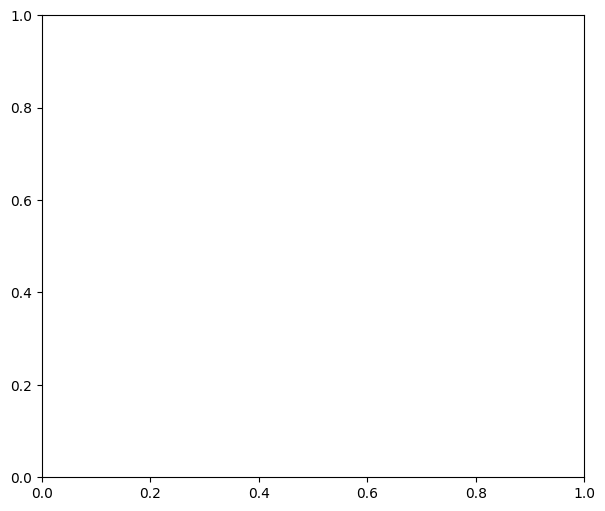

In [38]:
fig, ax = plt.subplots(figsize=(7,6))

plot_data1 = (
    cm.impact.get_GHG(session)
    .T.groupby('process').sum().T
    .droplevel('year')
)/1000000

plot.waterfall(
    data=plot_data1,
    ax=ax,
    breaks = ['FAI (demand)'],
    cmap='Pastel1',
    edgecolor='grey',
    width=0.8,
    label='absolute'
)

ax.axhline(y=plot_data1.sum(axis=1).loc['baseline'], xmin=0, xmax=1, zorder=0, linestyle='--', linewidth=0.8, color='lightgrey')

ax.set_title('Agricultural GHG emissions')
ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel('1000 tonnes CO2-eq')
ax.set_ylim(top=plot_data1.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.tight_layout()
plt.show()

In [21]:
session

,calculated
year,
2020,2025-01-12 17:21:29
,calculated
year,
2020,2025-01-12 17:49:21
,calculated
year,
2020,2025-01-12 18:04:54
,calculated
year,
